In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from ANEMO import read_edf
import numpy as np
%matplotlib inline

In [2]:
import glob
liste = {'pari':{}, 'enregistrement':{}}

for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste[a[0]][a[1]] = a[2]+'_'+a[3]

SUJETS = liste['pari'].keys() # ['BMC'] #
data, exp = {}, {}

for s in SUJETS :
    with open('data/pari_%s_%s.pkl'%(s, liste['pari'][s]), 'rb') as fichier :
        exp[s] = pickle.load(fichier, encoding='latin1')
    
    resultats = os.path.join('..','data', 'enregistrement_' + s + '_' + liste['enregistrement'][s] + '.asc')
    data[s] = read_edf(resultats, 'TRIALID')

In [3]:
from ANEMO import ANEMO
from aSPEM import Analysis

In [4]:
raw_size = {}
for s in SUJETS :
    raw_size[s] = []
    A = ANEMO(exp[s])
    N_blocks, N_trials = exp[s]['N_blocks'], exp[s]['N_trials']
    for block in range(N_blocks) :
        for trial in range(N_trials) :
            trial_data = trial + N_trials*block
            arg = A.arg(data[s][trial_data], trial=trial, block=block)
            taille = data[s][trial_data]['size']
            
            for sacc in arg.saccades :
                taille[sacc[0]-arg.t_0 -5 : sacc[1]-arg.t_0 +15] = np.nan
            
            raw_size[s].extend(list(taille))

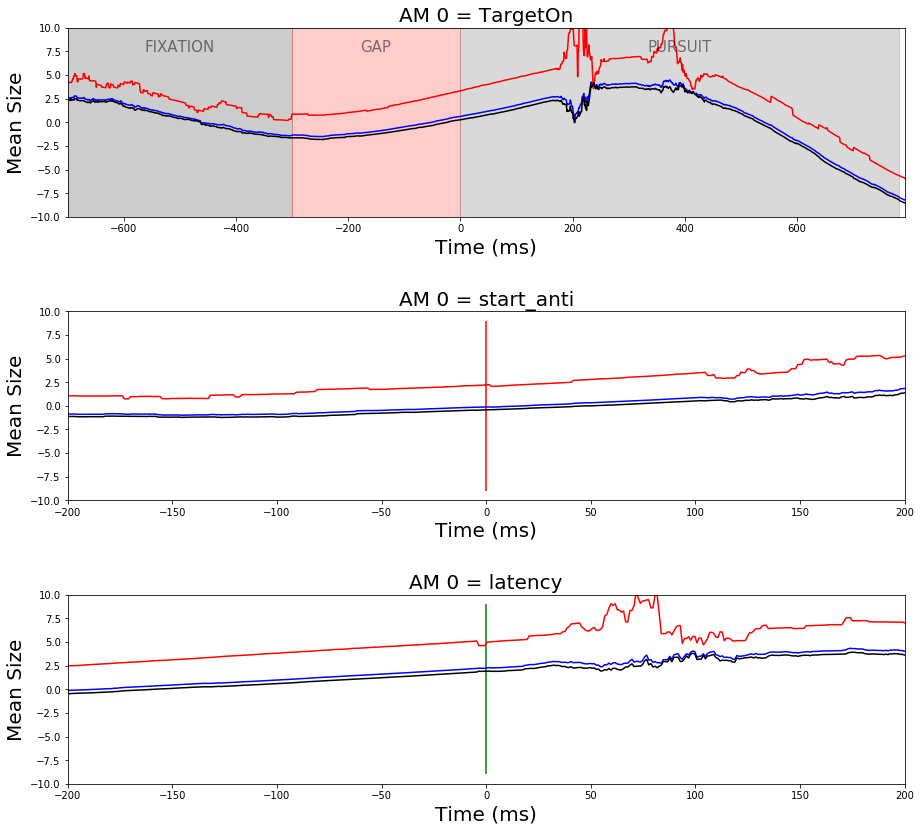

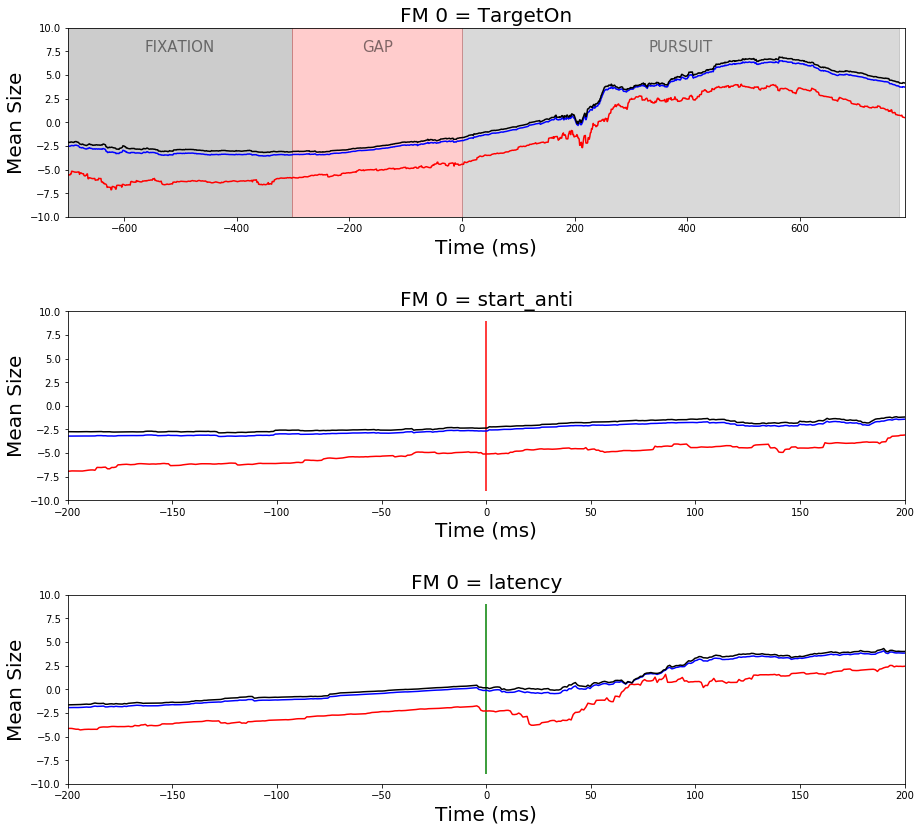

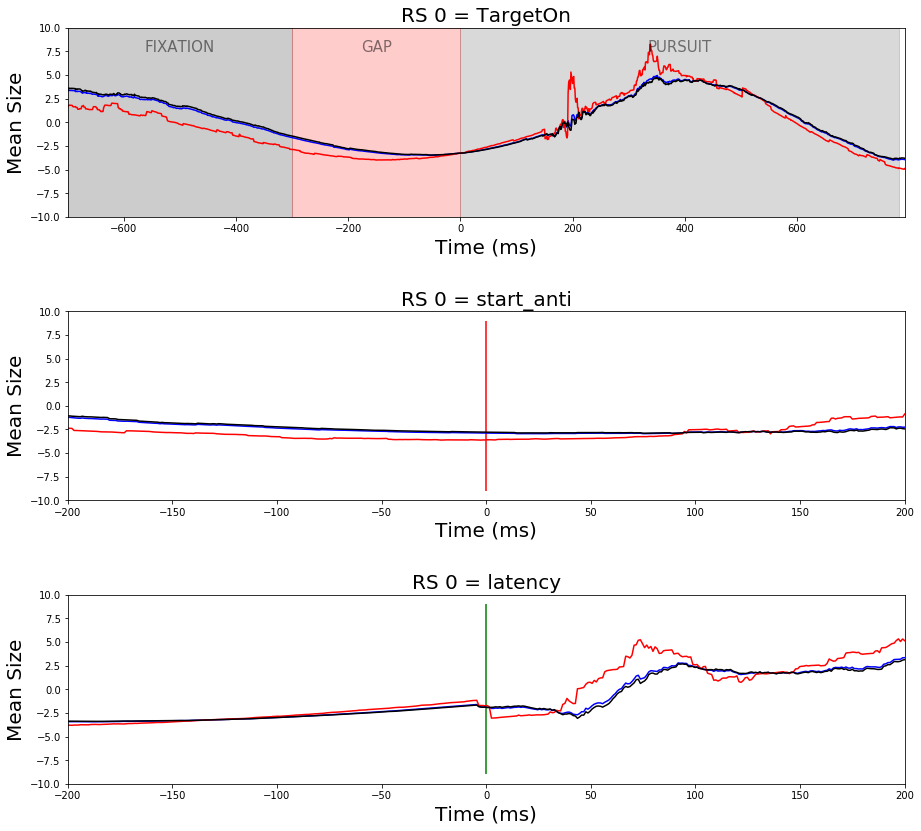

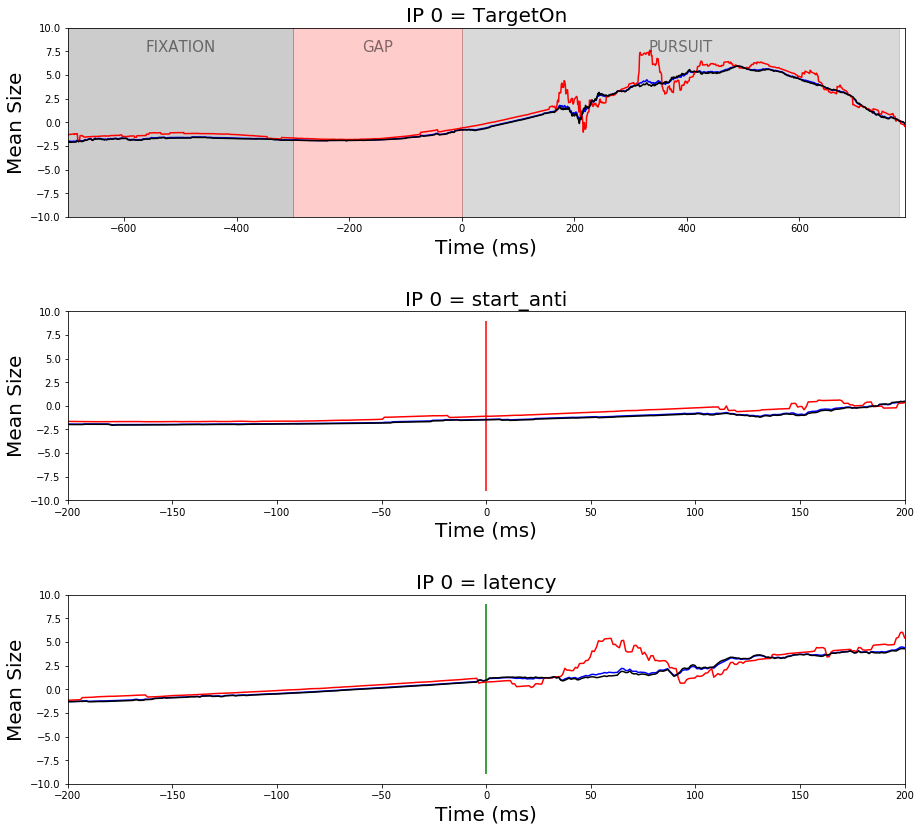

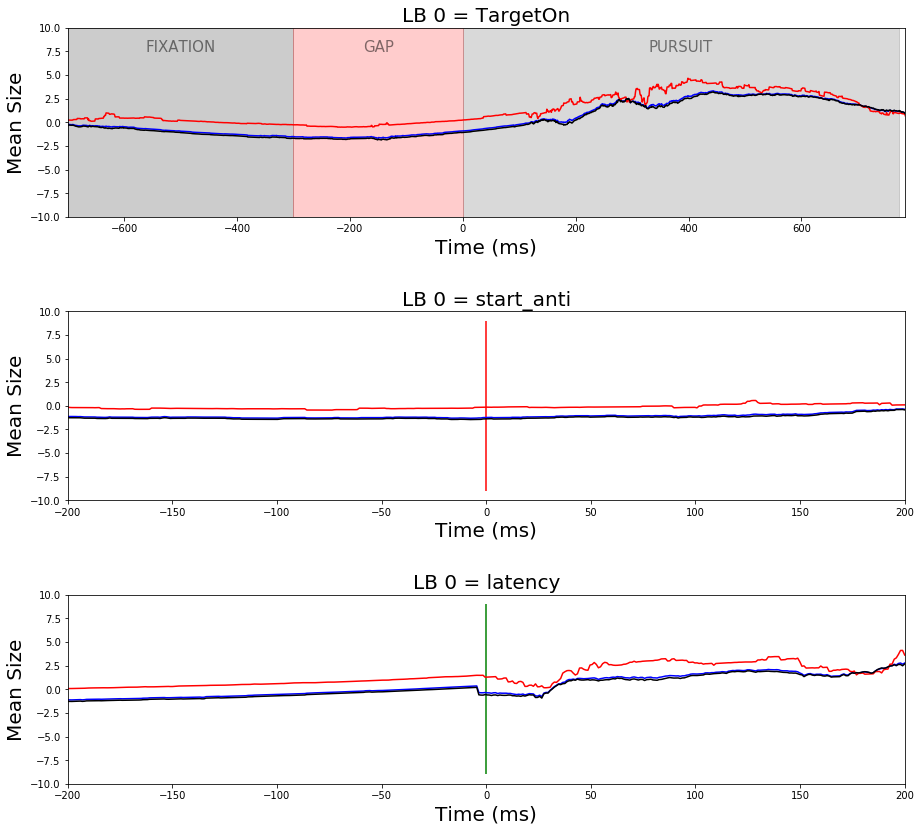

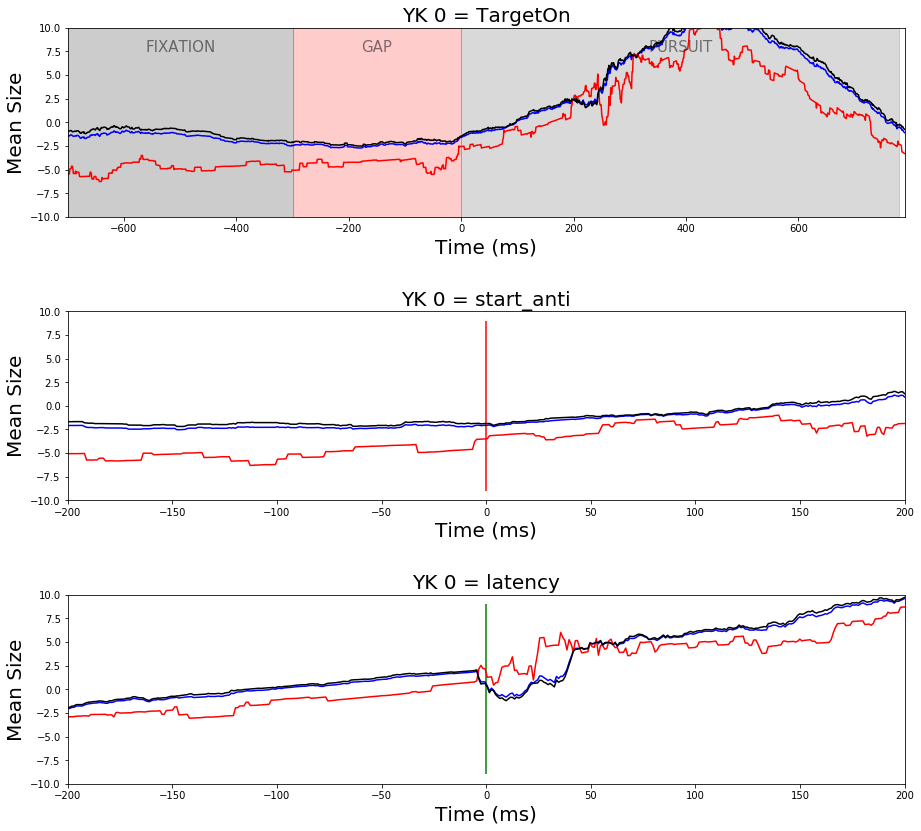

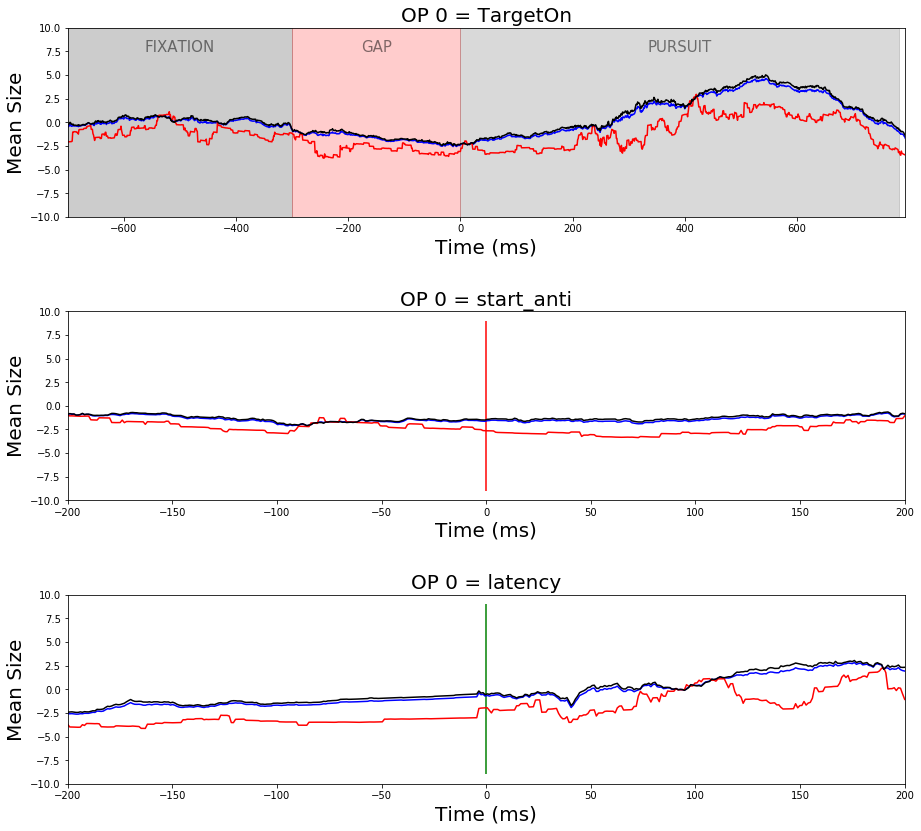

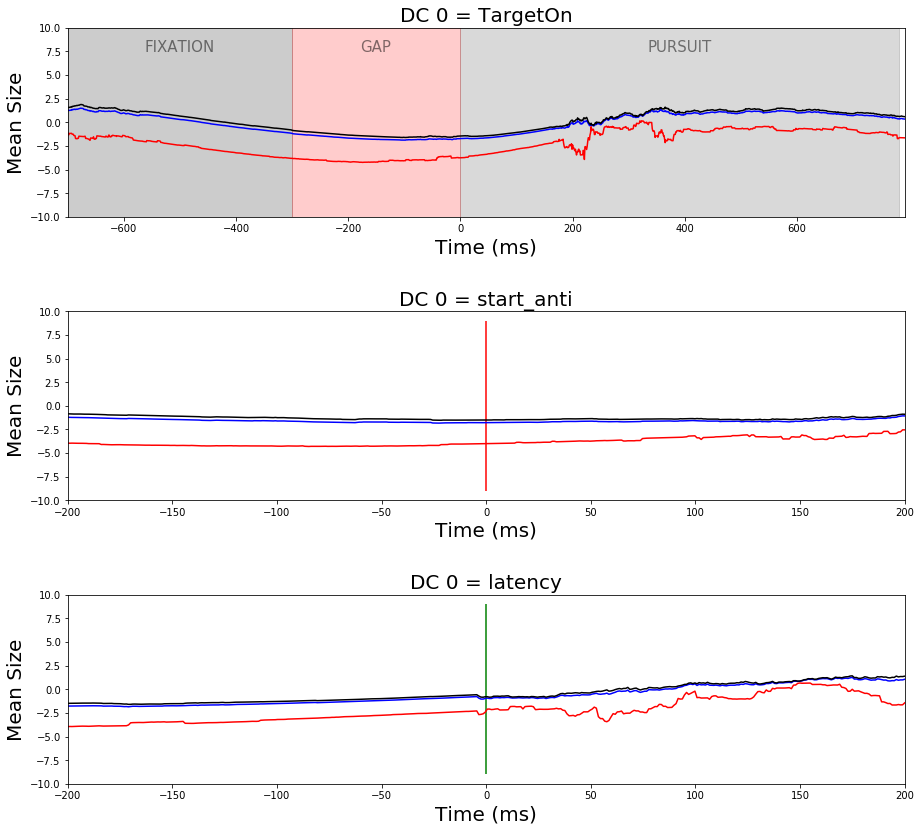

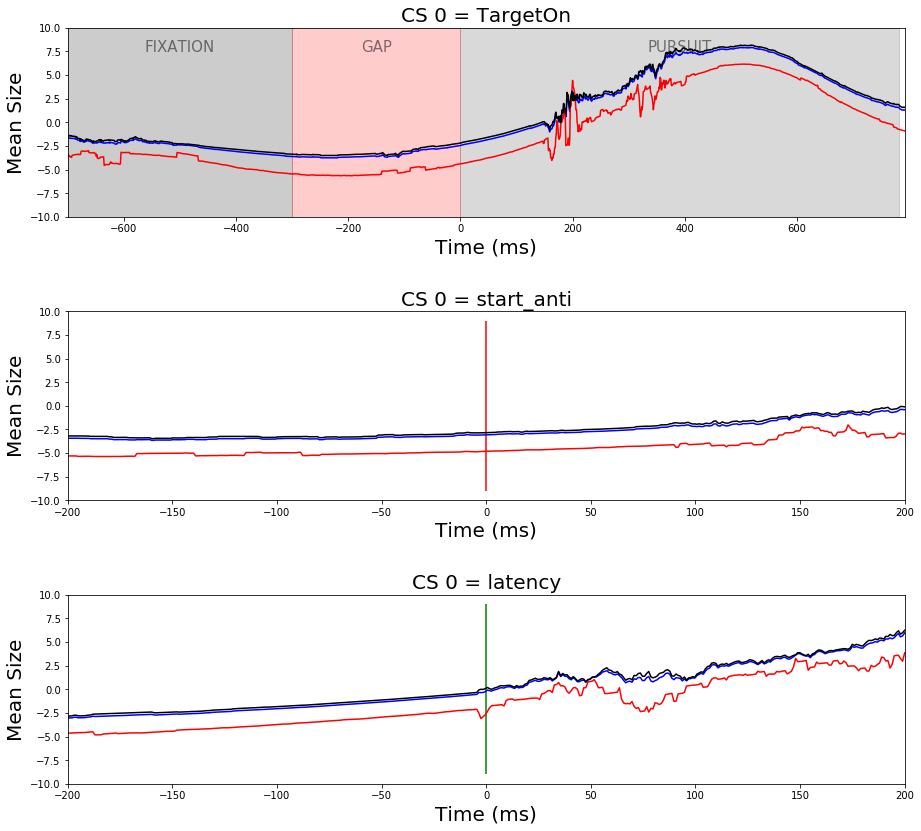

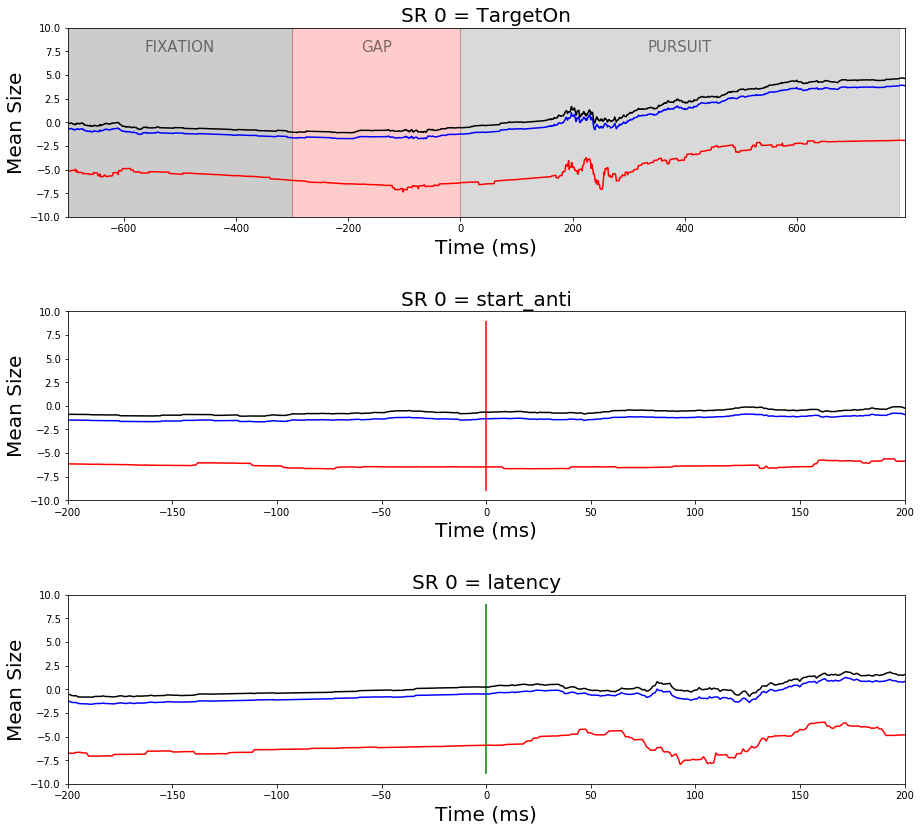

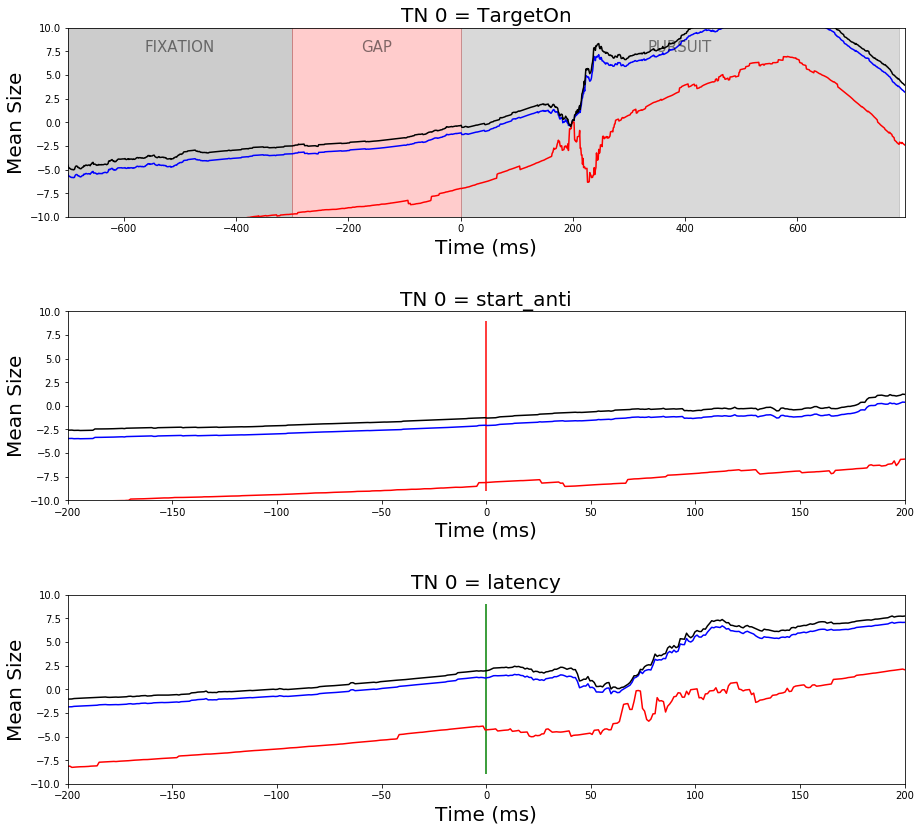

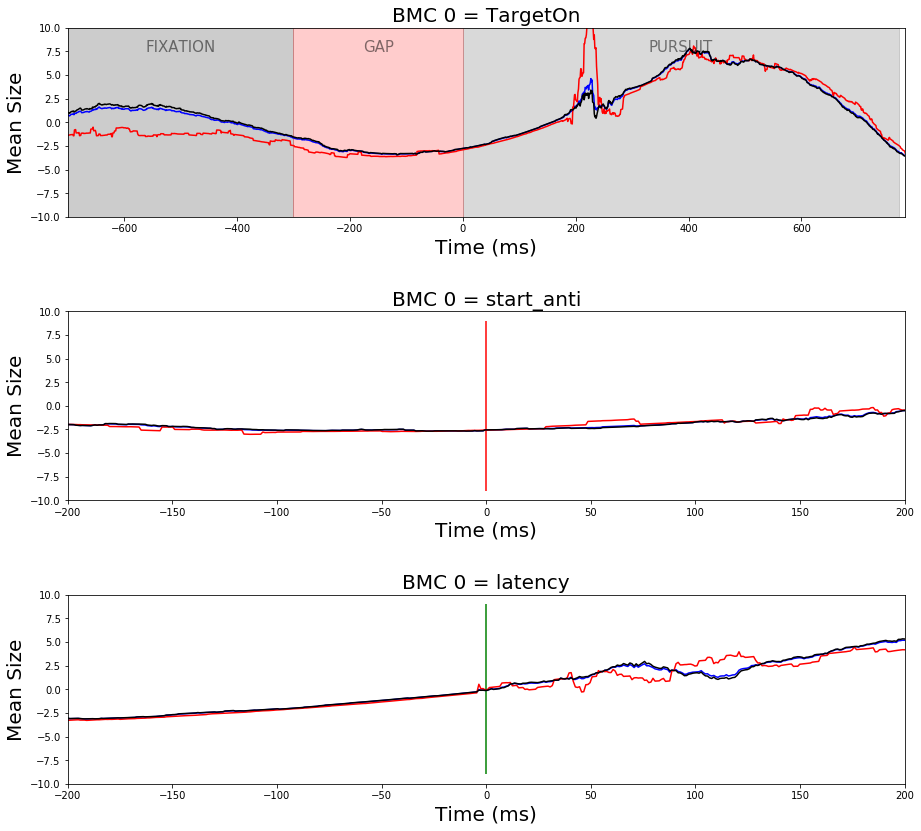

In [5]:
do_mean = True #False

fig_width=15
t_label, t_text = 20, 14

for s in SUJETS :
    
    size, size_anti, size_latency = [], [], []
    size_switch, size_anti_switch, size_latency_switch = [], [], []
    size_noswitch, size_anti_noswitch, size_latency_noswitch = [], [], []
    
    e = Analysis(observer=s, name_file_fit='fct_velocity_sigmo')
    A = ANEMO(exp[s]) 
    N_blocks, N_trials = exp[s]['N_blocks'], exp[s]['N_trials']
    
    for block in range(N_blocks) :
        
        #fig, ax = e.plot_data(trials=list(np.arange(10)), block=block)
        
        switch = np.where(exp[s]['p'][:, block, 2]==1)[0]
        
        for trial in range(N_trials) :
            trial_data = trial + N_trials*block
            arg = A.arg(data[s][trial_data], trial=trial, block=block)
            
            TarOn_0 = arg.TargetOn-arg.t_0
            start = TarOn_0-700
            stop = TarOn_0+800
            tps = arg.trackertime[start:stop]-arg.TargetOn
            
            start_anti = e.ENREGISTREMENT[s]['start_anti'][block][trial]
            latency = e.ENREGISTREMENT[s]['latency'][block][trial]
            
            taille = data[s][trial_data]['size']
            for sacc in arg.saccades :
                taille[sacc[0]-arg.t_0 -5 : sacc[1]-arg.t_0 +15] = np.nan
            
            taille_anti = taille[int(start_anti)+TarOn_0-200:int(start_anti)+TarOn_0+200]
            if do_mean: taille_anti = taille_anti/np.nanmean(raw_size[s]) #np.nanmean(taille_anti)
            if len(taille_anti) != 0 : size_anti.append(taille_anti)
            
            taille_latency = taille[int(latency)+TarOn_0-200:int(latency)+TarOn_0+200]
            if do_mean: taille_latency = taille_latency/np.nanmean(raw_size[s]) #np.nanmean(taille_latency)
            if len(taille_latency) != 0 : size_latency.append(taille_latency)
            
            taille = taille[start:stop]
            if do_mean: taille = taille/np.nanmean(raw_size[s]) #np.nanmean(taille)
            if len(taille) != 0 : size.append(taille)
            
            
            swiswi=False
            
            for sw in switch :
                if trial in np.arange(sw+2, sw+7) :
                    #print(trial)
                    swiswi=True
                    if len(taille) != 0 :         size_switch.append(taille)
                    if len(taille_anti) != 0 :    size_anti_switch.append(taille_anti)
                    if len(taille_latency) != 0 : size_latency_switch.append(taille_latency)
            
            if swiswi is False:
                if len(taille) != 0 :         size_noswitch.append(taille)
                if len(taille_anti) != 0 :    size_anti_noswitch.append(taille_anti)
                if len(taille_latency) != 0 : size_latency_noswitch.append(taille_latency)

            #if trial<10 :
            #    ax[trial].plot(tps, 100*taille - 100, c='r' )
            #    ax[trial].vlines(start_anti, -30, 30, color='r')
            #    ax[trial].vlines(latency, -30, 30, color='g')
        #plt.show()
        

    fig, ax = plt.subplots(3, 1, figsize=(fig_width, 3*(fig_width*(1/2))/1.6180))
    fig.subplots_adjust(hspace=0.5)

    start = arg.TargetOn
    time_s = arg.trackertime-start
    TarOn_s, TarOff_s  = arg.TargetOn-start,   arg.TargetOff-start
    StimOn_s, StimOf_s = arg.StimulusOn-start, arg.StimulusOf - start

    onset = arg.TargetOn-arg.t_0
    start, stop = onset-700, onset+800
    tps = time_s[start:stop]

    for i in range(len(ax)) :
        ax[i].set_ylabel('Mean Size', fontsize=t_label, color='k')
        ax[i].set_xlabel('Time (ms)', fontsize=t_label, color='k')

        
    ax[0].set_title('%s 0 = TargetOn'%s, fontsize=t_label, color='k')
    if do_mean: ax[0].axis([TarOn_s-700, TarOff_s+10, -10, 10])

    ax[0].axvspan(StimOn_s, StimOf_s, color='k', alpha=0.2)
    ax[0].axvspan(StimOf_s, TarOn_s,  color='r', alpha=0.2)
    ax[0].axvspan(TarOn_s,  TarOff_s, color='k', alpha=0.15)

    ax[0].text(StimOf_s+(TarOn_s-StimOf_s)/2,            8, "GAP",      color='k', size=t_label*.75, ha='center', va='center', alpha=0.5)
    ax[0].text((TarOn_s-700)+(StimOf_s-(TarOn_s-700))/2, 8, "FIXATION", color='k', size=t_label*.75, ha='center', va='center', alpha=0.5)
    ax[0].text(TarOn_s+(TarOff_s-TarOn_s)/2,             8, "PURSUIT",  color='k', size=t_label*.75, ha='center', va='center', alpha=0.5)

    for sisi, c in zip([size, size_switch, size_noswitch], ['b', 'r', 'k']) :
        ax[0].plot(tps, 100*np.nanmean(sisi, axis=0)-100, c=c)

        
    tps_anti = np.linspace(-200, 200, len(size_anti[0]))

    for i, c in enumerate(['r', 'g']) :
        if do_mean: ax[i+1].axis([-200, 200, -10, 10])
        ax[i+1].vlines(0, -9, 9, color=c)

    ax[1].set_title('%s 0 = start_anti'%s, fontsize=t_label, color='k')
    for sisi, c in zip([size_anti, size_anti_switch, size_anti_noswitch], ['b', 'r', 'k']) :
        ax[1].plot(tps_anti, 100*np.nanmean(sisi, axis=0)-100, c=c)

    ax[2].set_title('%s 0 = latency'%s, fontsize=t_label, color='k')
    for sisi, c in zip([size_latency, size_latency_switch, size_latency_noswitch], ['b', 'r', 'k']) :
        ax[2].plot(tps_anti, 100*np.nanmean(sisi, axis=0)-100, c=c)

    plt.show()